In [1]:
import os
import time
import sys
import json
import numpy as np
import ipyvolume as ipv
from pathlib import Path
import numpy as np
import random
import datetime

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.generation import ellipsoid_sheet
from tyssue.draw import sheet_view
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.behaviors.events import EventManager
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
from tyssue.io import hdf5


from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.ellipsoid import model
from invagination.delamination import (define_mesoderm,
                                       check_enter_in_process,
                                       check_tri_faces,
                                       type1_transition)

from invagination.plots import mesoderm_position


import matplotlib.pyplot as plt

%matplotlib inline

#SIM_DIR = Path('/media/data/Simulations/mesoderm_invagination/')
SIM_DIR = Path('/home/admin-suz/Documents/test')

today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_principal_results'
#sim_save_dir = SIM_DIR/f'2018-03-02'
try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

## Parameters



In [2]:
specs =  {
    'vert': {
        'is_active': 1,
        'x': 0.0,
        'y': 0.0,
        'z': 0.0,
        'rho': 0,
        'height': 0,
        'basal_shift': 0,
        'delta_rho': 30,
        'vitelline_K': 280.0,
        'radial_tension': 0},
    'face': {
        'is_alive': 1,
        'x': 0.0,
        'y': 0.0,
        'z': 0.0,
        'num_sides': 6,
        'area': 1.0,
        'perimeter': 1.0,
        'contractility': 1.12,
        'prefered_area': 22,
        'area_elasticity': 1,
    },
    'cell': {
        'vol': 100.0,
        'vol_elasticity': 5e-3,
        'prefered_vol': 100.0,
    },
    'edge': {
        'is_active': 1,
        'srce': 0,
        'trgt': 0,
        'face': 0,
        'cell': 0,
        'dx': 0.0,
        'dy': 0.0,
        'dz': 0.0,
        'nx': 0.0,
        'ny': 0.0,
        'nz': 0.0,
        'ux': 0.0,
        'uy': 0.0,
        'uz': 0.0,
        'length': 0.0,
        'sub_vol': 0.0,
        'sub_area': 0.0,
        'line_tension': 0.0,
    },
    'settings': {
        'abc': [12, 12, 21.0], # Ellipsoid axes
        'geometry': 'cylindrical',
        'height_axis': 'z',
        'nrj_norm_factor': 1,
        'vitelline_space': 0.2,
        'threshold_length': 1e-3,
    }
}


## Epithelium generation

`tyssue` provides functions to create epithelium with various base geometries, such as planes or ellipses.

In [3]:
sheet = ellipsoid_sheet(*specs['settings']['abc'], 13)
print(f'The sheet has {sheet.Nf} vertices')
sheet.update_specs(specs)


geom.update_all(sheet)

def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'colormap': 'Blues'
        }
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

The sheet has 184 vertices


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.636902, 0.856542, 0.21662 ],
       [0.233603, 0.313828, 0.543914],
       [0.281412, 0.155834, 0.469201],
       ...,
       [0.172719, 0.448791, 0.557885],
       [0.168126, 0.459988, 0.558082],
       [0.169646, 0.456262, 0.55803 ]]), lines=array([[351, 350],
       [285, 187],
       [304, 351],
       ...,
       [147,  41],
       [149, 148],
       [  0, 115]], dtype=uint32), texture=None, x=array([-14.30449813, -16.65548957, -11.17761852, -20.10260107,
       -19.14674427,  -4.87771506,  -3.28546456,  -6.99058103,
       -10.07524992, -19.98187304,   1.48809171,  -1.6924145 ,
         1.48809171,  -0.10059815,  -3.28546456,  -0.10059815,
        -1.6924145 ,  -3.28546456,  -4.25135589,   4.65785969,
         3.07174019,  -3.28546456, -13.74018616,  -9.94406149,
       -15.98185809,   3.07174019,   4.64825305, -13.39607544,
       -13.98274681, -15.18237745, -10.2626651 ,  -3.28546456,
        -6.99058103, -10.07524992,   1.48809171,   1.48809171,
        -0.10059815,   1.48809171,   1.48809171,  -0.10059815,
         3.07174019,  -3.28546456, -13.74018616,  -9.94406149,
         1.48809171,   1.48809171,  -0.10059815,   1.48809171,
         1.48809171,  -0.10059815,   3.07174019,   4.64825305,
         5.68188012,   3.07174019,   4.64825305,   3.07174019,
       -13.39607544, -13.98274681, -16.36152324, -15.18237745,
       -17.70441429, -18.50176807, -18.12407007, -15.98185809,
       -14.30449813, -13.30617397, -13.06161093, -16.7757135 ,
         9.26290709, -11.17761852, -10.2626651 , -13.30617397,
        -6.02644997,  -9.12613794,  -9.03472274, -12.59399043,
       -12.27297334, -12.59399043, -12.27297334,  -9.57753383,
        -8.50286059,  -9.62623704,  -4.59770764,  -4.88604732,
        -4.9093017 ,  -6.24057235,  -4.87771506,   3.07174019,
         4.29994285,   3.07174019,  10.0555855 ,   9.31562638,
        17.51344637,   3.07174019,   3.07174019, -11.96178801,
       -11.96178801,  -7.29186147,  -7.29186147,  -5.21753623,
        -9.35051683,  -9.57753383,  -8.55344931,  -9.57753383,
       -13.06161093, -18.12407007,  -0.10059815,   1.48809171,
        -1.6924145 ,  -1.6924145 ,  -0.10059815,   1.48809171,
         4.68066542,  16.56537098,  11.5713125 , -16.65548957,
       -16.36152324, -19.98187304, -15.45930909, -15.45930909,
       -18.06311471, -17.69801591, -18.06311471, -17.69801591,
        -9.57753383,  -8.50286059,  -9.62623704,  -4.59770764,
        -4.88604732,  -0.10059815,  -0.10059815,   1.48809171,
        -0.10059815,  -1.6924145 ,  -1.6924145 ,   1.48809171,
        -0.10059815,  -5.21753623,  -9.35051683,  -9.57753383,
        -8.55344931,  -9.57753383,  -0.10059815,  -0.10059815,
        -0.10059815,   1.48809171,  -1.6924145 ,  -1.6924145 ,
        -0.10059815,   1.48809171,  12.7889942 ,   8.33714573,
         5.91671513,   4.68066542,   3.95316813,  -9.12613794,
       -16.41999363, -14.4776269 ,   3.07174019,   3.07174019,
        12.01309772,   9.26290709,   8.30492873,   9.62230798,
         9.26290709,  12.01309772,   3.07174019,   8.30492873,
         3.07174019,   4.29994285,  -6.46680474,  -9.11124275,
        -9.57753383,  -6.46680474,  -9.11124275,  -9.57753383,
        10.65408955,  19.5470009 ,  20.68796994,  20.68796994,
        19.5470009 ,  15.05806144,  13.64565962,  12.19009523,
        12.19009523,   4.64825305,   7.01989306,   4.64825305,
         9.26290709,  13.51275531,  11.5713125 ,   9.42030717,
         9.26290709,   4.64825305,   4.89316137,   4.64825305,
         7.01989306,   9.16038437,   5.91671513, -13.42741803,
        -9.62460192, -13.8513165 ,  -9.66211369, -10.2685107 ,
       -11.08608331, -18.92551582, -14.71450108, -14.71450108,
       -15.47192049,   3.07174019,   3.07174019,

## Quasi-static model for mesoderm invagination


$$E = \sum_\alpha \frac{1}{2}\left(K_A(A - A_0)^2 + \Gamma L_\alpha^2\right) 
     + \sum_i \left(\delta_i R_i h_i + \frac{K_v}{2} r_i^2\right) + \frac{K_Y}{2}(V-V_0)^2$$ 

In [4]:
print('Our model has the following elements :')
print('\t', *model.labels, sep='\n\t')

Our model has the following elements :
	
	Apical basal tension
	Vitelline elasticity
	Contractility
	Area elasticity
	Volume elasticity


In [5]:
# Modify some initial values

sheet.cell_df['prefered_vol'] = sheet.cell_df['vol'].mean()
sheet.face_df['prefered_area'] = sheet.face_df['area'].mean()

geom.update_all(sheet)

### Gradient descent

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


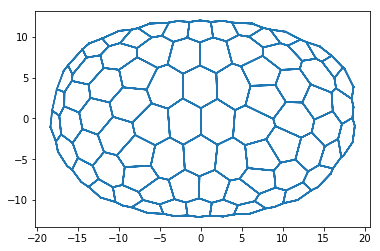

In [6]:
solver_kw = {'minimize': {'method': 'L-BFGS-B',
                          'options': {'ftol': 1e-8,
                                      'gtol': 1e-8}}}

res = Solver.find_energy_min(sheet, geom, model, **solver_kw)
res.fun
print(res.message)
fig, ax = sheet_view(sheet, coords=list('zx'), mode='quick')

In [7]:
ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))

ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.525776, 0.833491, 0.288127],
       [0.227802, 0.326594, 0.546532],
       [0.277134, 0.185228, 0.489898],
       ...,
       [0.162142, 0.474838, 0.55814 ],
       [0.154815, 0.493313, 0.55784 ],
       [0.171176, 0.45253 , 0.557965]]), lines=array([[351, 350],
       [285, 187],
       [304, 351],
       ...,
       [147,  41],
       [149, 148],
       [  0, 115]], dtype=uint32), texture=None, x=array([-14.44042513, -15.64224103, -11.81087428, -17.67658766,
       -17.04609242,  -5.55924748,  -3.92159534,  -7.04473308,
       -10.72353157, -17.4404213 ,   2.04271485,  -1.94888409,
         1.71560772,  -0.16073215,  -3.76513597,   0.02492875,
        -2.13384822,  -4.02074356,  -6.01626784,   5.71855143,
         3.12343653,  -4.05477561, -12.03606641, -11.21215781,
       -14.84313084,   3.83914168,   4.91108281, -12.47874466,
       -13.20458928, -13.6999453 , -10.23972974,  -3.92159534,
        -7.04473308, -10.72353157,   1.11627775,   1.35106446,
        -0.21646232,   1.11627775,   1.35106446,  -0.21646232,
         3.12343653,  -4.05477561, -12.03606641, -11.21215781,
         1.23693877,   1.50117432,  -0.11229735,   1.23693877,
         1.50117432,  -0.11229735,   3.83914168,   4.91108281,
         7.98782181,   3.94097974,   5.41378765,   4.18584127,
       -12.47874466, -13.20458928, -14.99711706, -13.6999453 ,
       -16.64488167, -17.27251629, -16.6657144 , -14.84313084,
       -14.44042513, -12.57306686, -12.26426671, -15.73687286,
         9.00990774, -11.81087428, -10.23972974, -12.57306686,
        -8.02289703, -10.72435646,  -8.35871898, -12.23264867,
       -10.41330052, -12.23264867, -10.41330052,  -9.55985932,
        -7.58920066,  -9.2786277 ,  -5.1335334 ,  -6.09988478,
        -6.60730654,  -7.76312683,  -5.28170838,   3.57150711,
         4.74107108,   2.75338777,   9.73691507,   8.94573041,
        15.88272653,   2.77776307,   2.77776307,  -9.9665746 ,
        -9.9665746 ,  -6.22481671,  -6.22481671,  -5.98410323,
        -7.63969663,  -8.4386492 ,  -7.77047498,  -9.85507324,
       -12.26426671, -16.6657144 ,   0.03120281,   2.01277155,
        -2.19162441,  -2.1616491 ,  -0.10026955,   1.90230252,
         6.08053103,  14.50845653,  10.3608784 , -15.64224103,
       -14.99711706, -17.4404213 , -14.60235468, -14.60235468,
       -16.31823076, -15.70909506, -16.31823076, -15.70909506,
        -9.55985932,  -7.58920066,  -9.2786277 ,  -5.1335334 ,
        -6.09988478,  -0.26173604,  -0.26173604,   2.04271485,
         0.02492875,  -2.13384822,  -1.94888409,   1.71560772,
        -0.16073215,  -5.98410323,  -7.63969663,  -8.4386492 ,
        -7.77047498,  -9.85507324,  -0.05230755,  -0.05230755,
         0.03120281,   2.01277155,  -2.19162441,  -2.1616491 ,
        -0.10026955,   1.90230252,  12.37534407,   7.62683098,
         7.55927027,   6.08053103,   5.4541601 , -10.72435646,
       -15.65238621, -13.9606615 ,   2.68651806,   2.68651806,
        10.0601742 ,   9.00990774,   7.14593817,  10.40896031,
         9.13173027,  10.0601742 ,   2.75338777,   7.14593817,
         3.57150711,   4.74107108,  -6.50292223,  -8.43649959,
        -9.45077944,  -6.50292223,  -8.43649959,  -9.45077944,
        11.54881502,  17.43885539,  18.55247506,  18.55247506,
        17.43885539,  14.28478213,  13.51074157,  11.83016672,
        11.83016672,   3.83113615,   6.278148  ,   4.61689633,
         8.46690794,  12.18225555,  10.3608784 ,  10.62719253,
         9.72047001,   4.61689633,   5.89117306,   3.83113615,
         6.278148  ,   7.63513212,   7.55927027, -13.67970619,
       -11.14434085, -13.47120795,  -9.50427667,  -9.97078399,
       -11.85603612, -16.20488527, -13.62156363, -13.62156363,
       -14.42237417,   3.94097974,   4.18584127,

number of apoptotic cells: 10


(<matplotlib.figure.Figure at 0x7efe8b01dcc0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efe83393160>,
       dtype=object))

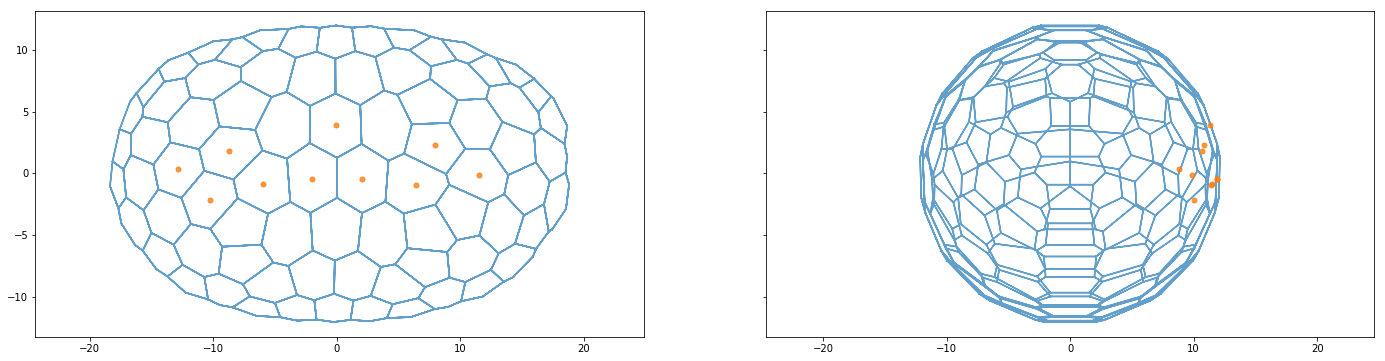

In [8]:
# Define ovoid mesoderm
define_mesoderm(sheet, a=15, b=4.)

mesoderm = sheet.face_df[sheet.face_df.is_mesoderm].index
delaminating_cells = sheet.face_df[sheet.face_df['is_mesoderm']].index
sheet.face_df['is_relaxation'] = False
print('number of apoptotic cells: {}'.format(delaminating_cells.size))
mesoderm_position(sheet, delaminating_cells)

In [9]:
from ipywidgets import IntProgress
from IPython.display import display

In [10]:
progress = IntProgress(min=0, max=40)

def run_sim(sheet, mesoderm, geom, model, dirname, progress, stop=40):
    progress.stop=40
   
    display(progress)
    delaminating_cells = []
    #Initiate manager
    manager = EventManager('face')
    sheet.face_df['enter_in_process'] = 0    
    while manager.current and manager.clock < stop:
        # Clean radial tension on all vertices
        sheet.vert_df['radial_tension'] = 0
        manager.execute(sheet)
        res = Solver.find_energy_min(sheet, geom, model, **solver_kw)

        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(manager.clock))
        hdfname = figname[:-3]+'hf5'
        hdf5.save_datasets(hdfname, sheet)      
        
        # Add cells in delamination process if they are authorized
        check_enter_in_process(sheet, manager, mesoderm, amp=0.3, )

        # Add cells with initially 3 neighbourghs to be eliminated
        check_tri_faces(sheet, manager)
        # Add T1 transition for face with at least one edge shorter than critical length
        short_edges = sheet.edge_df['length'] < sheet.settings['threshold_length']
        for face in sheet.edge_df[short_edges]['face'].unique():
            manager.append(type1_transition, face,
                           kwargs={'critical_length':sheet.settings['threshold_length']})    
        manager.update()
        manager.clock += 1
        progress.value = manager.clock
    
    progress.stop = manager.clock
    return sheet

In [11]:

contractility_rate = 2
critical_area = 5
radial_tension = 60

# Directory definition 
dirname = '{}_contractility_{}_critical_area_{}_radialtension'.format(
            contractility_rate, critical_area, radial_tension)
dirname = os.path.join(sim_save_dir, dirname)

print('starting {}'.format(dirname))
try:
    os.mkdir(dirname)
except IOError:
    pass

settings = {'contract_rate': contractility_rate,
            'critical_area': critical_area,
            'radial_tension': radial_tension,
            'nb_iteration': 10,
            'contract_neighbors':False,
            'geom': geom}


# Add some information to the sheet
sheet2 = sheet.copy(deep_copy=True)
sheet2.face_df['id'] = sheet2.face_df.index.values
sheet2.settings['delamination'] = settings

sheet2 = run_sim(sheet2, delaminating_cells, 
                 geom, model, dirname, progress)

print('{} done'.format(dirname))
print('~~~~~~~~~~~~~~~~~~~~~\n')
    

starting /home/admin-suz/Documents/test/2018-09-11_principal_results/2_contractility_5_critical_area_60_radialtension


IntProgress(value=0, max=40)

/home/admin-suz/Documents/test/2018-09-11_principal_results/2_contractility_5_critical_area_60_radialtension done
~~~~~~~~~~~~~~~~~~~~~



In [13]:
hfs = [f  for f in os.listdir(dirname) if f.endswith('hf5')]
hfs.sort()
from tyssue.draw.ipv_draw import edge_mesh, face_mesh

def get_meshes(dirname, hdf_file):
    dsets = hdf5.load_datasets(os.path.join(dirname, hdf_file),
                               data_names=['vert', 'edge', 'face'])
        
    sheet = Sheet('ellipse', dsets)
    faces = face_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.face_df['area'],
                      color_range=(0, 30))
    
    edges = edge_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.vert_df.y)
    return faces, edges

from ipywidgets import interact

def browse_sheets(dirname, hfs):
    n = len(hfs)
    ipv.clear()
    fig = ipv.gcf()
    meshes = get_meshes(dirname, hfs[0])
    fig.meshes = fig.meshes + list(meshes)
    
    def view_sheet(i):
        fig.animation = 0

        faces, edges = get_meshes(dirname, hfs[i])
        print()
        fig.meshes[0].x = faces.x
        fig.meshes[0].y = faces.y
        fig.meshes[0].z = faces.z
        fig.meshes[0].color = faces.color
        fig.meshes[0].triangles = faces.triangles

        fig.meshes[1].x = edges.x
        fig.meshes[1].y = edges.y
        fig.meshes[1].z = edges.z
        fig.meshes[1].color = edges.color
        fig.meshes[1].lines = edges.lines

        lim_inf = sheet.vert_df[sheet.coords].min().min()
        lim_sup = sheet.vert_df[sheet.coords].max().max()
        ipv.xyzlim(lim_inf, lim_sup)
    ipv.show()
    interact(view_sheet, i=(0, n-1))


In [14]:
browse_sheets(dirname, hfs)

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.123463, 0.581687, 0.547445],
       [0.132444, 0.552216, 0.553018],
       [0.124395, 0.578002, 0.548287],
       ...,
       [0.122312, 0.633153, 0.530398],
       [0.122312, 0.633153, 0.530398],
       [0.123463, 0.581687, 0.547445]]), texture=None, triangles=array([[ 150,  184, 1272],
       [  30,  185, 1273],
       [ 150,  186, 1274],
       ...,
       [  60, 1269, 2357],
       [  59, 1270, 2358],
       [   0, 1271, 2359]], dtype=uint32), x=array([-3.49167177, -0.61424217,  0.35327774, ...,  6.59439018,
        6.46668453, -2.987343  ]), y=array([  7.32072946,   5.70744258,   8.80855614, ...,  -9.99153044,
       -10.3459322 ,   5.92303969]), z=array([-13.77843317, -15.98479101, -12.86573139, ...,  -4.05431767,
        -0.09969878, -15.6421147 ])), Mesh(color=array([[0.525776, 0.833491, 0.288127],
       [0.227802, 0.326594, 0.546532],
       [0.277134, 0.185228, 0.489898],
       ...,
       [0.162142, 0.474838, 0.55814 ],
       [0.154815, 0.493313, 0.55784 ],
       [0.171176, 0.45253 , 0.557965]]), lines=array([[351, 350],
       [285, 187],
       [304, 351],
       ...,
       [147,  41],
       [149, 148],
       [  0, 115]], dtype=uint32), texture=None, x=array([ -1.29123732,  -2.987343  ,  -4.1007321 ,  -2.82883767,
        -1.94079255,  -3.26429561,  -7.4940199 ,  -9.95701468,
        -8.38961323,  -4.04481303,  -3.20848191,  -6.23742063,
        -6.28121277,  -7.06070154,  -2.31187099,  -1.98038799,
        -3.19862225,   1.19919938,   1.85437658,  -6.05747408,
         9.42048041,   6.59439018,   9.76886818,   8.81352722,
         0.71973191,   6.71238814,   6.35824249,  -7.39857417,
        -5.76683297,  -8.34636821,  -4.48969656,  -7.4940199 ,
        -9.95701468,  -8.38961323, -11.85960206, -10.30018537,
        -9.74565694, -11.85960206, -10.30018537,  -9.74565694,
         9.42048041,   6.59439018,   9.76886818,   8.81352722,
        11.79403639,   9.88967056,   9.28216399,  11.79403639,
         9.88967056,   9.28216399,   6.71238814,   6.35824249,
        -2.52451774,  -2.28527897,  -3.25355023,   1.02445308,
        -7.39857417,  -5.76683297,  -4.81700626,  -8.34636821,
         3.21700962,   0.33286044,   1.48132752,   0.71973191,
        -1.29123732,  -1.98687897,   7.71997621,   4.58448403,
       -10.81126822,  -4.1007321 ,  -4.48969656,  -1.98687897,
        -2.01898864,   0.21066694,  -0.49548836,  -9.65115711,
       -10.20054131,  -9.65115711, -10.20054131,  -8.11812626,
        -8.9728952 ,  -5.93223444,  -7.21233068,  -5.76835445,
         3.51783346,   7.48208451,   6.17895856,  -7.57701253,
        -7.35528898,  -9.91428721,  -5.39803802,  -6.36609988,
        -6.72599638,  11.91199162,  11.91199162,  10.69765348,
        10.69765348,  11.58159631,  11.58159631,   9.89810958,
        11.03390251,  10.85043924,   8.5941055 ,   9.20258641,
         7.71997621,   1.48132752,   1.2614291 ,   2.38470434,
         2.4516568 ,   5.46187221,   6.46668453,   5.52746934,
         3.98640786,   8.80301023,  10.58663736,  -2.987343  ,
        -4.81700626,  -4.04481303,  -7.74868876,  -7.74868876,
        -5.80032787,  -6.25396504,  -5.80032787,  -6.25396504,
        -8.11812626,  -8.9728952 ,  -5.93223444,  -7.21233068,
        -5.76835445, -12.02865212, -12.02865212,  -3.20848191,
        -1.98038799,  -3.19862225,  -6.23742063,  -6.28121277,
        -7.06070154,   9.89810958,  11.03390251,  10.85043924,
         8.5941055 ,   9.20258641,  11.97337871,  11.97337871,
         1.2614291 ,   2.38470434,   2.4516568 ,   5.46187221,
         6.46668453,   5.52746934,   7.03722374,   8.67051987,
         7.6482453 ,   3.98640786,   1.60034567,   0.21066694,
         5.37819831,   7.42176513, -11.96663332, -11.96663332,


interactive(children=(IntSlider(value=15, description='i', max=30), Output()), _dom_classes=('widget-interact',))